In [ ]:
import numpy as np
import pandas as pd
import glob
import re 
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def readData(folder):
    data = []
    print('Reading  ' + folder + 'neg ...')
    for filename in glob.glob(folder + 'neg/*'):
        with open(filename, 'r', encoding="utf8") as f:
            review = f.readlines()
            data.append([0, review[0]])
    print('Reading  ' + folder + 'pos ...')
    for filename in glob.glob(folder + 'pos/*'):
        with open(filename, 'r', encoding="utf8") as f:
            review = f.readlines()
            data.append([1, review[0]])
    
    
    return pd.DataFrame(data, columns=['Labels', 'Reviews'])

def readFile(filename):
    data = []
    with open(filename, encoding="ISO-8859-1") as f:
        for line in f:
            data.append(line.strip())
    return data
    

In [ ]:
!unzip "Programming_Assignment_3.zip"

In [ ]:
data_dir = "/content/Dataset/"
train = readData(data_dir + 'train/')
test = readData(data_dir + 'test/')
train.head()

Reading  /content/Dataset/train/neg ...
Reading  /content/Dataset/train/pos ...
Reading  /content/Dataset/test/neg ...
Reading  /content/Dataset/test/pos ...


,Labels,Reviews
0,0,"I wanted to like this film, yes its a SAW, bla..."
1,0,An accurate review of nuremburg must consider ...
2,0,Wha-BAM! Someone surely had fun devouring a wh...
3,0,I saw this movie twice through a pentecostal c...
4,0,"I like Fulci films, i really do and not in som..."


In [ ]:
test.shape

(25000, 2)

In [ ]:
negWords = readFile(data_dir + 'negative_words.txt')
posWords = readFile(data_dir + 'positive_words.txt')
stopWords = readFile(data_dir + 'stop_words.txt')


print(stopWords[:10])

['i', "i'm", 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you']


In [ ]:
#Removes unwanted characters from the dataset
def removeUnwantedChars(review):
  
  # Converts to lower
    result = review.lower()
  # Removes stop words
    result = ' '.join(filter(lambda x: x not in stopWords,  result.split()))
  # Removes numbers
    result = re.sub(r'\d+', '', result)
  # Removes punctuactions
    result = re.sub(r'[^\w\s]',' ', result)
  # Removes leading and trailing white spaces
    result = result.strip()

    return result

In [ ]:
#apply remove unwanted chars function
train['preprocessedReviews'] = train['Reviews'].apply(removeUnwantedChars)
test['preprocessedReviews'] = test['Reviews'].apply(removeUnwantedChars)
train.head()

,Labels,Reviews,preprocessedReviews
0,0,"I wanted to like this film, yes its a SAW, bla...",wanted like film yes saw blah blah blah ripo...
1,0,An accurate review of nuremburg must consider ...,accurate review nuremburg must consider door h...
2,0,Wha-BAM! Someone surely had fun devouring a wh...,wha bam someone surely fun devouring whole tr...
3,0,I saw this movie twice through a pentecostal c...,saw movie twice pentecostal church family atte...
4,0,"I like Fulci films, i really do and not in som...",like fulci films really boring ironic way eit...


In [ ]:
def createX0(review):
    return 1

def createX1(review):
    count = 0
    for word in review.split():
        if word not in posWords:
            count += 1
    return count

def createX2(review):
    count = 0
    for word in review.split():
        if word not in negWords:
            count += 1
    return count

In [ ]:
train['X0'] = train['preprocessedReviews'].apply(createX0)
train['X1'] = train['preprocessedReviews'].apply(createX1)
train['X2'] = train['preprocessedReviews'].apply(createX2)

test['X0'] = test['preprocessedReviews'].apply(createX0)
test['X1'] = test['preprocessedReviews'].apply(createX1)
test['X2'] = test['preprocessedReviews'].apply(createX2)
test.tail()

,Labels,Reviews,preprocessedReviews,X0,X1,X2
24995,1,Spoilers !!! To understand what really happene...,spoilers understand really happened first ...,1,277,256
24996,1,"This was a romantic, simple funny movie. I rea...",romantic simple funny movie really enjoyed w...,1,58,64
24997,1,This is an astonishing film: a romantic thrill...,astonishing film romantic thriller convoluted...,1,140,148
24998,1,Edward Dmytryk directed this shadowy movie abo...,edward dmytryk directed shadowy movie murder i...,1,76,71
24999,1,I know Gerrit. He presently lives in the U.S. ...,know gerrit presently lives u s film based e...,1,63,64


In [ ]:
X_train = train[['X0', 'X1', 'X2']]
Y_train = train[['Labels']]

X_test = train[['X0', 'X1', 'X2']]
Y_test = train[['Labels']]

In [ ]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))

def propogate(x, w):
  
    z = np.dot(x,w.T)
    y = sigmoid(z)
    return y

def crossentropy(pred, true):
    m = pred.shape[0]
    epsilon = 1e-6
    return (-1/m) * np.sum(true * np.log(pred + epsilon)+(1 - true) * np.log(1 - pred + epsilon))    

def gradientDescent(x, y, n_epochs, learning_rate):
    loss = []
    accuracy = []
    w = np.zeros((1,x.shape[1]))
    for i in range(n_epochs):
        m = x.shape[0]
        h_x = propogate(x, w)
        
        error = h_x - y
        dw = (1/m) * (error.T @ x)
            
        w = w - (learning_rate * dw) 
        loss.append(crossentropy(h_x, y))
            
        h_x = np.where(h_x < 0.5, 0, 1)
        accuracy.append(np.mean(h_x == y) * 100)

    return accuracy, loss, w, 

def predict(x, w):
    h_x = propogate(x, w)
    h_x = np.where(h_x < 0.5, 0, 1)
  
    return h_x

def confusionMatrix(pred, true):
    tp, tn, fp, fn = 0, 0, 0, 0       
    pred = np.where(pred <= 0.5, 0, 1)
        
    for x,y in zip(pred,true):          
        if x==1 and y==1:
            tp += 1        
        elif x==0 and y==0:
            tn += 1          
        elif x==1 and y==0:
            fn += 1
        elif x==0 and y==1:
            fp += 1

    print("["+ str(tp)+ ","+ str(fp) +"]")
    print("["+ str(fn)+ ","+ str(tn) +"]")

def plotting(loss, n_epochs):
    plt.xlabel("no. of iterations/ epochs")
    plt.ylabel("training loss")
    plt.title("Training Loss over No of iterations")
    plt.plot(list(range(0,n_epochs)),loss)

In [ ]:
accuracy, loss, weights = gradientDescent(X_train, Y_train, n_epochs=1500, learning_rate=0.0001)

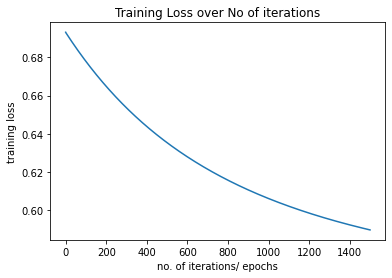

In [ ]:
plotting(loss, n_epochs=1500)

In [ ]:
pred = predict(X_test, weights)
print("Prediction Accuracy is %", (np.mean(pred == Y_test) * 100))

Prediction Accuracy is % Labels    72.532
dtype: float64


In [ ]:
def confusionMatrix(pred, true):
    tp, tn, fp, fn = 1, 0, 0, 0       
    pred = np.where(pred <= 0.5, 0, 1)
    for x,y in zip(pred,true['Labels']):          
        if x==1 and y==1:
            tp += 1        
        elif x==0 and y==0:
            tn += 1          
        elif x==1 and y==0:
            fn += 1
        elif x==0 and y==1:
            fp += 1

    print("["+ str(tp)+ ","+ str(fp) +"]")
    print("["+ str(fn)+ ","+ str(tn) +"]")

In [ ]:
confusionMatrix(pred, Y_test)

[9993,2508]
[4359,8141]


# Part 2

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [ ]:
X_train = (train[['X0', 'X1', 'X2']]).to_numpy()
Y_train = (train[['Labels']]).to_numpy()

X_test = (train[['X0', 'X1', 'X2']]).to_numpy()
Y_test = (train[['Labels']]).to_numpy()

In [ ]:
model = LogisticRegression(random_state=0).fit(X_train,Y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
pred = model.predict(X_test)

accuracy = accuracy_score(Y_test,pred)
print("Prediction Accuracy is %.2f %%"% (accuracy *100))

Prediction Accuracy is 72.88 %


In [ ]:
print(confusion_matrix(Y_test,pred))

[[9127 3373]
 [3406 9094]]
